In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
from torch import utils as t_utils
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torchaudio
import numpy as np
import sys
import os
from torchaudio.utils import download_asset
from helpers import train_loop, test_loop
from IPython.display import Audio
from os import walk
import glob
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm

sys.dont_write_bytecode = True
torch.manual_seed(17)



#### Utils

In [2]:
# waveform, sample_rate = torchaudio.load('./data/train_audio/yebduc1/XC201443.ogg')
# waveform, sample_rate = torchaudio.load('./data/train_audio/yebduc1/XC290158.ogg')

# def record_to_frames(waveform, sample_rate, frame_size=5):
#     p1d = (1, sample_rate * frame_size)
#     out = torch.nn.functional.pad(waveform, p1d, "constant", 0)
#     return out.unfold(1, sample_rate * frame_size, sample_rate * frame_size)

# print(f"{waveform.shape[1] / sample_rate} seconds")
# print(waveform.shape)
# out = record_to_frames(waveform, sample_rate)
# print(f"{out.shape[2] / sample_rate} seconds")

# print(out.shape)
# p1d = (1, sample_rate * 5) # pad last dim by 1 on each side
# out = torch.nn.functional.pad(waveform, p1d, "constant", 0)
# print(waveform.shape[1] / sample_rate)
# print(out.shape)
# print(sample_rate)
# print(out.shape[1] / sample_rate)
# plot_specgram(waveform, sample_rate)
# plot_specgram(out, sample_rate)

## Creating data loader

In [3]:
class_names = sorted(os.listdir('./data/train_audio/'))
class_names_dic = {class_names[i]: i for i in range(0, len(class_names))}
paths = glob.glob("./data/train_audio/**/*.ogg")
print(paths[0].split('\\')[-2])
# df = pd.DataFrame(data={'x': paths, 'y': [x.split('/')[3] for x in paths]})
df = pd.DataFrame(data={'x': paths, 'y': [x.split('\\')[-2] for x in paths]})
df['y'] = df['y'].map(class_names_dic)

df.head()
# class_names_dic


abethr1


,x,y
0,./data/train_audio\abethr1\XC128013.ogg,0
1,./data/train_audio\abethr1\XC363501.ogg,0
2,./data/train_audio\abethr1\XC363502.ogg,0
3,./data/train_audio\abethr1\XC363503.ogg,0
4,./data/train_audio\abethr1\XC363504.ogg,0


torch.Size([1, 104490])


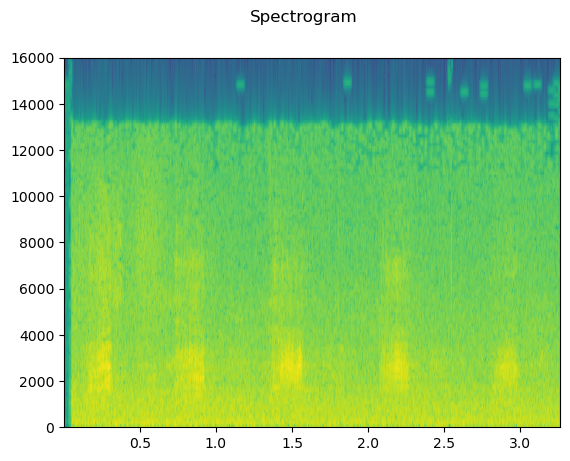

In [4]:
waveform, sample_rate = torchaudio.load('./data/train_audio/yebduc1/XC201443.ogg')
print(waveform.shape)
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    # figure.canvas.draw()
    # data = np.frombuffer(figure.canvas.tostring_rgb(), dtype=np.uint8)
    # data = data.reshape(figure.canvas.get_width_height()[::-1] + (3,))
    # print(data.shape)
    plt.show(block=False)

plot_specgram(waveform, sample_rate)

In [5]:
# waveform.unfold(1, sample_rate * 5, sample_rate * 5).shape

In [6]:
num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sample_rate

print(time_axis.shape)
print(num_frames / sample_rate)
print(num_channels, num_frames)
# x.unfold(0, 2, 1)

# plot_specgram(waveform, sample_rate)
# Audio(waveform.numpy(), rate=sample_rate)

torch.Size([104490])
3.2653125
1 104490


Shape of spectrogram: torch.Size([1, 201, 523])
(201, 523)


<Figure size 640x480 with 0 Axes>

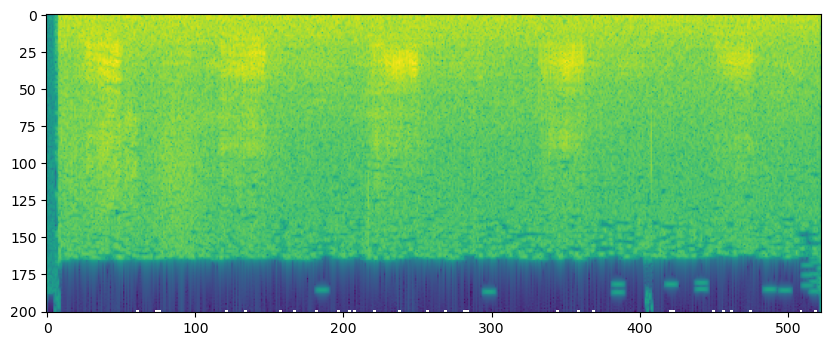

In [28]:

audio_spectogram = torchaudio.transforms.Spectrogram(power=1, n_fft=1024)(waveform)
 
print("Shape of spectrogram: {}".format(audio_spectogram.size()))
plt.figure()
plt.figure(figsize=(10,10))
print(audio_spectogram.log2()[0,:,:].numpy().shape)
plt.imshow(audio_spectogram.log2()[0,:,:].numpy() )

In [8]:
class TrainAudioDataset(Dataset):
    def __init__(self, df):
        self.df = df
        # self.spectrogram = torchaudio.transforms.Spectrogram( )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = df.iloc[idx]
        label = row['y'] 
        waveform, sample_rate = torchaudio.load(row['x'])
 
        # audio_spectogram = self.spectrogram(waveform)
        # print(sample_rate)
        # return (waveform, sample_rate), label
        return (waveform[0], sample_rate), label

In [9]:
a = TrainAudioDataset(df)

len(a)
 

16941

In [10]:

 
# create dataset
dataset = TrainAudioDataset(df)
 
# split dataset
rows = len(dataset) 
test_size = int(rows*0.2)
train_size = rows - test_size
trainDataset, testDataset = random_split(dataset, [train_size, test_size])

# init loaders
batch_size = 32
learning_rate = 1e-3 
epochs = 5

def record_to_frames(waveform, sample_rate, frame_size=5):
    p1d = (1, sample_rate * frame_size)
    out = torch.nn.functional.pad(waveform, p1d, "constant", 0)
    return out.unfold(0, sample_rate * frame_size, sample_rate * frame_size)
spectogram = torchaudio.transforms.Spectrogram(power=1)
def my_collate(batch):
    # print(batch)
    # a, b = batch[0]
    frames = []
    labels = []

    for (data,label) in batch:
        waveform, sample_rate = data
        # print(f"{waveform.shape[0] / sample_rate} seconds")

        l_frames = record_to_frames(torch.tensor(waveform), sample_rate)
        # print(len(l_frames))
        for frame in l_frames:
            audio_spectogram = spectogram(frame)
            audio_spectogram = audio_spectogram.repeat(3, 1, 1) 
            # print(audio_spectogram.size())
            frames.append(audio_spectogram.numpy())
            labels.append(label ) 
    
 
    return [frames, labels]
# mainLoader = DataLoader(trainDataset, batch_size=batch_size, collate_fn=my_collate)
trainLoader = DataLoader(trainDataset, batch_size=batch_size, collate_fn=my_collate)
testLoader = DataLoader(testDataset, batch_size=batch_size, collate_fn=my_collate)

In [20]:
 
q = iter(trainLoader)
# next(q)
# next(q)

In [12]:
torch.cuda.empty_cache()

In [13]:

from torchsummary import summary
torch.cuda.empty_cache()

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential( 
            nn.Conv2d(kernel_size=3, stride=1, padding=0, in_channels=3, out_channels=6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3), 
            nn.Flatten(),
            nn.Linear(105336, len(class_names))
        )

    def forward(self, x):
        # x = torch.unsqueeze(x, 0)
        # print('in:', x.size())
        logits = self.linear_relu_stack(x)
        # print('out:', logits.size())

        # print(logits.size())
        return logits
    

model = NeuralNetwork().to(device) 
# print(model)

summary(model, input_size=(3, 201, 801))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 199, 799]             168
              ReLU-2          [-1, 6, 199, 799]               0
         MaxPool2d-3           [-1, 6, 66, 266]               0
           Flatten-4               [-1, 105336]               0
            Linear-5                  [-1, 264]      27,808,968
Total params: 27,809,136
Trainable params: 27,809,136
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.84
Forward/backward pass size (MB): 16.17
Params size (MB): 106.08
Estimated Total Size (MB): 124.09
----------------------------------------------------------------


In [17]:
def train_loop(dataloader, model, criteria, optimizer ):
    size = len(dataloader.dataset)
    count = 0
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X = torch.FloatTensor(X).to(device)
        y = torch.as_tensor(y).to(device)
        pred = model(X) 
        loss = criteria(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        print(batch)
        if batch % 64 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loop(trainLoader, model, loss_fn, optimizer)

0it [00:00, ?it/s]C:\Users\yatsy\AppData\Local\Temp\ipykernel_18160\1913016251.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_frames = record_to_frames(torch.tensor(waveform), sample_rate)
1it [00:13, 13.69s/it]

0
loss: 5.367166  [  311/13553]


1it [00:29, 29.08s/it]


KeyboardInterrupt: 

In [22]:
q = iter(trainLoader)
X, y = next(q)
 
with torch.no_grad():
    pred = model(torch.FloatTensor(X ).to(device) )
    print(torch.argmax(pred ))
    print(y[0])


C:\Users\yatsy\AppData\Local\Temp\ipykernel_18160\1913016251.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_frames = record_to_frames(torch.tensor(waveform), sample_rate)


tensor(15797, device='cuda:0')
247


In [26]:
X, y = next(q)
 
with torch.no_grad():
    pred = model(torch.FloatTensor(X ).to(device) )
    print(torch.argmax(pred ).cpu().numpy())
    print(y )

C:\Users\yatsy\AppData\Local\Temp\ipykernel_18160\1913016251.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_frames = record_to_frames(torch.tensor(waveform), sample_rate)


3653
[169, 169, 169, 169, 169, 169, 169, 169, 219, 49, 49, 73, 73, 73, 73, 73, 73, 29, 29, 29, 84, 84, 72, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 30, 30, 30, 30, 30, 30, 30, 245, 245, 245, 245, 74, 74, 74, 74, 131, 131, 131, 131, 131, 131, 131, 131, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 55, 55, 55, 55, 55, 55, 55, 55, 55, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 135, 135, 135, 103, 103, 103, 103, 103, 103, 103, 103, 89, 89, 89, 89, 89, 89, 89, 89, 174, 174, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 88, 88, 88, 247, 247, 135, 135, 135, 114, 114, 20, 20, 20, 74, 74, 74, 70, 70, 70, 70, 70, 74, 74, 74, 70, 70, 70, 12, 12, 12, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 166, 166, 166, 166, 166, 166]


In [ ]:
X, y = next(q)
 
with torch.no_grad():
    pred = model(torch.FloatTensor(X[0]).to(device) )
    print(torch.argmax(pred[0]))
    print(y[0])

tensor(20, device='cuda:0')
88


C:\Users\yatsy\AppData\Local\Temp\ipykernel_21912\3753541001.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_frames = record_to_frames(torch.tensor(waveform), sample_rate)


In [ ]:
from statistics import mode

size = len(testLoader.dataset)
num_batches = len(testLoader)
correct = 0
test_loss = 0
with torch.no_grad():
    for (X, y) in testLoader:
        results = np.array([])
        # for i in range(len(X)):
        #     frame = torch.FloatTensor(X[i]).to(device)
        #     locY = torch.zeros(1, len(class_names)).to(device)
        #     # locY[0][y[i]] = 1
            
        #     pred = model(frame)
        #     res = torch.argmax(pred[0]).cpu().numpy()
        #     results = np.append(results, res) 
        pred = model(torch.FloatTensor(X))
        # print(len(results))
        # print(mode(results))
        # print(len(y))
        # pred = model(X)
        # test_loss += loss_fn(pred, torch.FloatTensor(y).to(device)).item()
        correct += (mode(pred.argmax(1)) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

C:\Users\yatsy\AppData\Local\Temp\ipykernel_10432\1913016251.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_frames = record_to_frames(torch.tensor(waveform), sample_rate)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor